#### 氧化铁皮——>iron oxide scale;
#### 裂纹系翘皮——>Cracked skin;
#### 精轧周期压痕——>Finish rolling cycle indentation;
#### 保护渣系夹渣——>slag inclusion in mold flux
#### 铁皮灰——>iron gray

### Dataset information
#### id: 1——name: iron_oxide
#### id: 2——name: cracked_skin
#### id: 3——name: rolling_cycle
#### id: 4——name: slag_inclusion
#### id: 5——name: iron_gray

In [4]:
file_path = "./Dataset/Annotation/Annotation.json"
import json
import os
from collections import Counter
import pandas as pd

with open(file_path,'r') as load_f:
    load_json = json.load(load_f)
path = "/home/dlsuncheng/Dataset/Steel_Defect/Train_Val_bbox/"
for category in os.listdir(path):
    category_path = path+category
    print("{}:{}".format(category,len(os.listdir(category_path))))
anno_class = []
for anno in load_json["annotations"]:
    anno_class.append(anno["category_id"])    
print(Counter(anno_class))
print(len(anno_class))

negative:2066
iron_oxide:396
cracked_skin:363
rolling_cycle:321
slag_inclusion:387
iron_gray:356
Counter({5: 576, 1: 567, 4: 430, 3: 375, 2: 364})
2312
796


### Area and H/w ratio distribution
#### according to coco, small objects are thoes with areas under 1024(32^2), medium objects are those with areas under 9216(64^2),areas of large objects are mainly above 9216
#### above all, in steel defect dataset, there are 542 small objects, 1157 medium objects and 613 large objects 

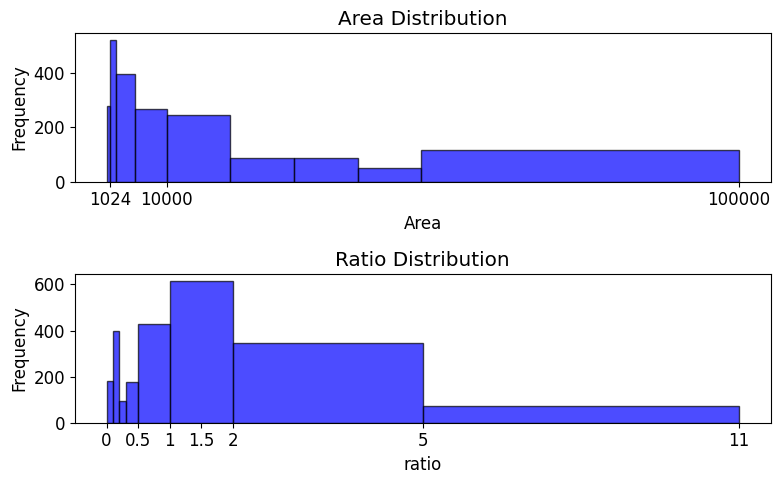

In [65]:
import json
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8.0, 5.0) 
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['figure.dpi'] = 100
plt.figure()
area = []
ratio = []
for anno in load_json["annotations"]:
    area.append(round(anno["area"],2))
    ratio.append(round(anno["bbox"][2]/anno["bbox"][3],2))
area.sort()
ratio.sort()
plt.subplot(211)
plt.hist(area, bins=(500,1024,2000,5000,10000,20000,30000,40000,50000,100000),facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xticks((1024,10000,100000),(1024,10000,100000))
plt.xlabel("Area")
# 显示纵轴标签
plt.ylabel("Frequency")
# 显示图标题
plt.title("Area Distribution")
plt.subplot(212)
plt.hist(ratio, bins=(0,0.1,0.2,0.3,0.5,1,2,5,10),facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xticks((0,0.5,1,1.5,2,5,10),(0,0.5,1,1.5,2,5,11))
plt.xlabel("ratio")
plt.ylabel("Frequency")

# 显示图标题
plt.title("Ratio Distribution")
plt.tight_layout()#调整整体空白
# plt.subplots_adjust(wspace =0, hspace =0)#调整子图间距
plt.show()

### optimize anchor generator

In [6]:
!python /home/hustwen/sun_chen/SteelDetection/SteelMMdet/tools/analysis_tools/optimize_anchors.py \
        /home/hustwen/sun_chen/SteelDetection/model/cascade_rcnn/cascade_rcnn_r101_fpn_1x_coco.py \
    --algorithm "k-means" \
    --input-shape 780 128 \
    --output-dir .\

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
2021-10-05 13:19:42,144 - mmdet - INFO - Collecting bboxes from annotation...
[>>>>>>>>>>>>>>>>>>>>>>>>>] 3112/3112, 26857.9 task/s, elapsed: 0s, ETA:     0s

2021-10-05 13:19:42,262 - mmdet - INFO - Collected 1854 bboxes.
2021-10-05 13:19:42,262 - mmdet - INFO - Start cluster 10 YOLO anchors with K-means...
[                             ] 18/1000, 410.6 task/s, elapsed: 0s, ETA:     2s2021-10-05 13:19:46,476 - mmdet - INFO - K-means process has converged at iter 18.


2021-10-05 13:19:46,477 - mmdet - INFO - Anchor cluster finish. Average IOU: 0.7079067826271057
2021-10-05 13:19:46,477 - mmdet - INFO - Anchor optimize result:[[11, 2], [37, 4], [11, 18], [21, 19], [57, 8], [154, 6], [57, 19], [113, 20], [258, 19], [519, 20]]
2021-10-05 13:19:46,478 - mmdet - INFO - Result saved in ./anchor_optimize_result.json


### train-val split

In [1]:
import json
import numpy as np
import copy
np.random.seed(1)
json_path = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation_num.json"
with open(json_path,'r') as load_f:
    load_json = json.load(load_f)
image_num = len(load_json["images"])
image_id_list = [i for i in range(1,image_num+1)]
all_list = dict(train=[],val=[])
np.random.shuffle(image_id_list)
split_point = image_num//5
all_list["val"].extend(image_id_list[:split_point])
all_list["train"].extend(image_id_list[split_point:])

In [38]:
for i in all_list:
    steel_defect_category = [{"id": 1, "name": "iron_oxide", "supercategory": "iron_oxide"}, 
        {"id": 2, "name": "cracked_skin", "supercategory": "cracked_skin"}, 
        {"id": 3, "name": "rolling_cycle", "supercategory": "rolling_cycle"}, 
        {"id": 4, "name": "slag_inclusion", "supercategory": "slag_inclusion"}, 
        {"id": 5, "name": "iron_gray", "supercategory": "iron_gray"}
        ]
    train_dict = {"images": [],
                    "type": "instances",
                    "annotations": [],
                    "categories": steel_defect_category}
    for images in load_json["images"]:
        if images["id"] in all_list[i]:
            train_dict["images"].append(images)
    for anno in load_json["annotations"]:
        if anno["image_id"] in all_list[i]:
            train_dict["annotations"].append(anno)
    with open(i+'_num.json', 'w') as fp:
      json.dump(train_dict, fp)

### check dataloader 

In [17]:
# Copyright (c) OpenMMLab. All rights reserved.

import numpy as np
from mmcv import Config, DictAction
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
cfg_path = "/home/dlsuncheng/Steel_Defect/model/FRCN_Baseline.py"
cfg = Config.fromfile(cfg_path)
cfg.gpu_ids = [1]
dataset = build_dataset(cfg.data.train)
print(dataset)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!

CocoDataset Train dataset with number of images 3112, and instance counts: 
+----------------+-------+------------------+-------+-------------------+-------+--------------------+-------+---------------+-------+
| category       | count | category         | count | category          | count | category           | count | category      | count |
+----------------+-------+------------------+-------+-------------------+-------+--------------------+-------+---------------+-------+
| 0 [iron_oxide] | 447   | 1 [cracked_skin] | 296   | 2 [rolling_cycle] | 288   | 3 [slag_inclusion] | 349   | 4 [iron_gray] | 474   |
|                |       |                  |       |                   |       |                    |       |               |       |
| -1 background  | 1657  |                  |       |                   |       |                    |       |               |       |
+----------------+-------+----

### check data wrapper

In [2]:
from mmdet.datasets.dataset_wrappers import ClassBalancedDataset,RepeatDataset
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
cfg_path = "/home/hustwen/sun_chen/SteelDetection/model/FRCN_baseline/FRCN_Baseline_dataset_wrapper.py"
from mmcv import Config, DictAction
cfg = Config.fromfile(cfg_path)
# print(cfg.data)
cfg.gpu_ids = [1]
dataset = build_dataset(cfg.data.train)
dataset.
# dataset = RepeatDataset(
#             build_dataset(cfg['dataset'], default_args), cfg['times'])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1455

### Image rename

In [3]:
path = "/home/dlsuncheng/Dataset/Steel_Defect/Final_num/"
import os
file_list = os.listdir(path)
file_list.sort()
rename_list = [str(index+4686).zfill(6) for index in range(len(file_list))]
for index in range(len(file_list)):
    print(file_list[index],rename_list[index]+file_list[index][-4:])    
    os.rename(path+file_list[index],path+rename_list[index]+file_list[index][-4:])

01275016_09_BF_00762.jpg 004686.jpg
CqQ9DF-zUuiANZ_8AAAthFuDHzY124.jpg 004687.jpg
CqQ9DF-zUvCARGUkAAAjtqgK2Ek861.jpg 004688.jpg
CqQ9DF-zUvWARR4PAAAxY_JYpPk296.jpg 004689.jpg
CqQ9DGAGx5uACh_xAAAnZhbAsWY331.jpg 004690.jpg
CqQ9DGAGx5uAKeDCAAA13-vWFfU821.jpg 004691.jpg
CqQ9DGAQ-baAGv-_AAAdDnET4ro688.jpg 004692.jpg
CqQ9DGAQ-baAI0v4AAAeK__uxo0607.jpg 004693.jpg
CqQ9DGAQ-beAFfvPAAAvqWMny3k254.jpg 004694.jpg
CqQ9DGAQ-beAJ4FQAAAmkr_O4Zw855.jpg 004695.jpg
CqQ9DGAQ-beAJgHwAAAnWaldHkw007.jpg 004696.jpg
CqQ9DGAQ-beANcrqAAAwwIYFiOo334.jpg 004697.jpg
CqQ9DGAQ-beAYeB7AAA8RhcewwQ256.jpg 004698.jpg
CqQ9DGAQ-beAbDgLAAAoQqxvjz0553.jpg 004699.jpg
CqQ9DGARAdCAMtjWAAA29znjsQw092.jpg 004700.jpg
CqQ9DGARAdGAX3KKAAAp8aqjWWA408.jpg 004701.jpg
P4040680_01270426_04_srcimg_0230.jpg 004702.jpg
P4040680_01270426_04_srcimg_0245.jpg 004703.jpg
P4040680_01270426_04_srcimg_0250.jpg 004704.jpg
P4040680_01270426_04_srcimg_0331.jpg 004705.jpg
P4040680_01270426_04_srcimg_0353.jpg 004706.jpg
P4040680_01270426_04_srcimg_0390.j

In [17]:
import json
path = "/home/dlsuncheng/Dataset/Steel_Defect/Annotation/Annotation.json"
with open(path,"r") as load_f:
    load_json = json.load(load_f)
final = {"images":[],"annotations":[],"category":load_json["categories"]}
final_num = {"images":[],"annotations":[],"category":load_json["categories"]}
for img in file_list:
    img_info = {"file_name": img, "id": int(rename_list[file_list.index(img)]), "width": 780, "height": 128}
    img_num_info = {"file_name": rename_list[file_list.index(img)]+img[-4:], "id": int(rename_list[file_list.index(img)]), "width": 780, "height": 128}
    final["images"].append(img_info)
    final_num["images"].append(img_num_info)
with open(os.path.split(path)[0]+'/final.json', 'w') as fp:
    json.dump(final, fp)
# with open(os.path.split(path)[0]+'/final_num.json', 'w') as fp:
#     json.dump(final_num, fp)

In [2]:
import json
json_path = "/home/hustwen/sun_chen/SteelDetection/Dataset/final.json"

with open(json_path,'r') as load_f:
    load_json = json.load(load_f)
for image in load_json["images"]:
    _,filename = os.path.split(image["file_name"])
    index = file_list.index(filename)
    image["file_name"]=rename_list[index]+file_list[index][-4:]
    image["id"] = index+3890
with open('test.json', 'w') as fp:
    json.dump(load_json, fp)

FileNotFoundError: [Errno 2] No such file or directory: '/home/hustwen/sun_chen/SteelDetection/Dataset/test.json'

In [2]:
test_path = "/home/dlsuncheng/Dataset/Steel_Defect/Annotation/test.json"
test_img_path = "/home/dlsuncheng/Dataset/Steel_Defect/Test/"
import os
import json
with open(test_path,"r") as load_f:
    load_json = json.load(load_f)
for img_info in load_json["images"]:
    new_path = os.path.split(img_info["file_name"])[-1]
    # test_img_path+os.path.split(img_info["file_name"])[-1]
    img_info["file_name"]=new_path
with open(test_path,"w") as load_f:
    json.dump(load_json,load_f)

### model ensemble

In [16]:
from ensemble_boxes import *
import json
iou_thr = 0.7
weights = [1,1]
skip_box_thr = 0
conf_type = "avg"
test_path = "/home/dlsuncheng/Dataset/Steel_Defect/Annotation/test.json"
with open(test_path,"r") as load_f:
    test_json = json.load(load_f)
test_list = [os.path.split(img["file_name"])[-1] for img in test_json["images"]]
test_list.sort()
json_path1 = "/home/dlsuncheng/Steel_Defect/Submit/best_result.json"
json_path2 = "/home/dlsuncheng/Steel_Defect/Submit/mixup_result.json"
def Test_Json_Info(json_path,test_list):
    box_list = []
    score_list = []
    label_list = []
    filename_list = []
    with open(json_path,"r") as load_f:
        load_json = json.load(load_f)
    for filename in test_list:
        for img in load_json:
            if filename in img["name"]:
                box_list.append([img["bbox"][0]/780,img['bbox'][1]/128,(img["bbox"][0]+img["bbox"][2]-1)/780,(img["bbox"][1]+img["bbox"][3]-1)/128])
                score_list.append(img["score"])
                label_list.append(img["category_id"])
                filename_list.append(filename)
    return box_list,score_list,label_list,filename_list
box_list_1,score_list_1,label_list_1 = Test_Json_Info(json_path1,test_list)
box_list_2,score_list_2,label_list_2 = Test_Json_Info(json_path2,test_list)
boxes_list = [box_list_1,box_list_2]
scores_list = [score_list_1,score_list_2]
labels_list = [label_list_1,label_list_2]
boxes,scores,labels = weighted_boxes_fusion(boxes_list,scores_list,labels_list, \
                                            weights=weights,iou_thr = iou_thr, \
                                            skip_box_thr = skip_box_thr, \
                                            conf_type=conf_type)
boxes = [[box[0]*780,box[1]*128,box[2]*780,box[3]*128]for box in boxes]

### semi_supervised

In [34]:
!python /home/dlsuncheng/Steel_Defect/semi_supervised/peduso_label.py /home/dlsuncheng/Steel_Defect/Submit/cascade_baseline_test_result.bbox.json /home/dlsuncheng/Steel_Defect/semi_supervised/

convert sucess!


In [33]:
supervised_label = "/home/dlsuncheng/Steel_Defect/Dataset/Annotation/Annotation.json"
blank_test = "/home/dlsuncheng/Dataset/Steel_Defect/Annotation/test.json"
with open(blank_test,'r') as load_f:
    blank_json = json.load(load_f)
with open(supervised_label,"r") as load_f:
    label_json = json.load(load_f)   

label_json["images"].extend(blank_json["images"])
print(len(label_json["images"]))

4685
